In [59]:
# !pip install huggingface_hub[hf_xet]

In [60]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import torch
from transformers import BertTokenizer, BertModel
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [61]:
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rajkumar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rajkumar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [62]:
file_path = r"D:\GUVI\Sentimental Project\chatgpt_style_reviews_dataset.xlsx - Sheet1.csv"
df = pd.read_csv(file_path)
df.head(5)

,date,title,review,rating,username,helpful_votes,review_length,platform,language,location,version,verified_purchase
0,2024-12-24,East list local interesting far magazine father.,Impressive natural language understanding. Alm...,1,darren55,25,9,Google Play,de,Nepal,2.0.4,No
1,2024-07-26,Road determine picture figure hard experience ...,Sometimes gives wrong answers or outdated info...,2,davistyler,35,14,Flipkart,es,Panama,2.6.5,No
2,2024-08-22,Policy social past analysis whole.,Great tool for generating content quickly. Int...,5,andrea59,94,10,App Store,es,Denmark,4.2.2,No
3,2025-04-24,News financial billion four foreign.,Great tool for generating content quickly. Sta...,3,dcooper,50,15,Amazon,de,Brunei Darussalam,4.4.2,No
4,2024-08-15,To skill she case sing stop likely.,Excellent for language translation and grammar...,1,christine79,33,11,Flipkart,fr,United States Minor Outlying Islands,5.1.1,Yes


In [63]:
# Ensure correct formats
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
df["date"] = pd.to_datetime(df["date"], errors="coerce")

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               50 non-null     datetime64[ns]
 1   title              50 non-null     object        
 2   review             50 non-null     object        
 3   rating             50 non-null     int64         
 4   username           50 non-null     object        
 5   helpful_votes      50 non-null     int64         
 6   review_length      50 non-null     int64         
 7   platform           50 non-null     object        
 8   language           50 non-null     object        
 9   location           50 non-null     object        
 10  version            50 non-null     object        
 11  verified_purchase  50 non-null     object        
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 4.8+ KB


C:\Users\Rajkumar\AppData\Local\Temp\ipykernel_16388\3699225721.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="rating", palette="viridis")


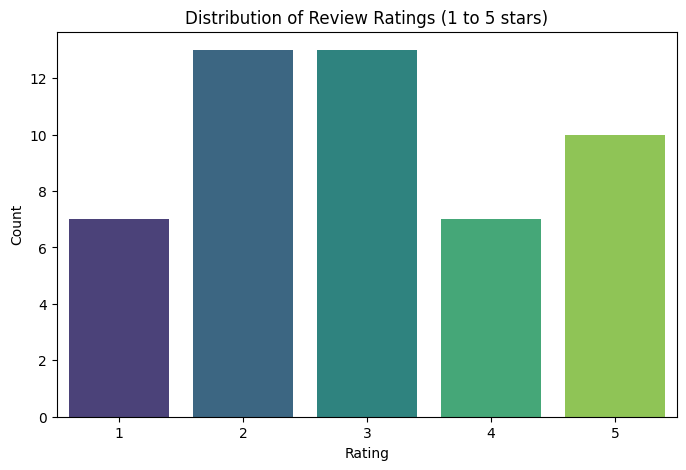

In [65]:
#1.
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="rating", palette="viridis")
plt.title("Distribution of Review Ratings (1 to 5 stars)")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


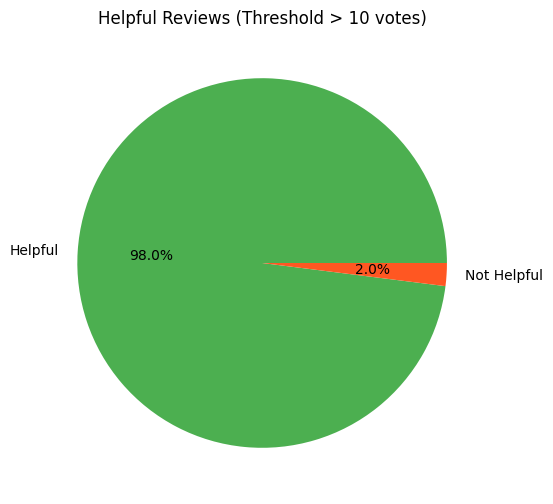

In [66]:
#2.
df["helpful_flag"] = df["helpful_votes"] > 10
helpful_counts = df["helpful_flag"].value_counts()

plt.figure(figsize=(6,6))
helpful_counts.plot.pie(
    autopct="%1.1f%%",
    labels=["Helpful", "Not Helpful"],
    colors=["#4CAF50", "#FF5722"]
)
plt.title("Helpful Reviews (Threshold > 10 votes)")
plt.ylabel("")
plt.show()


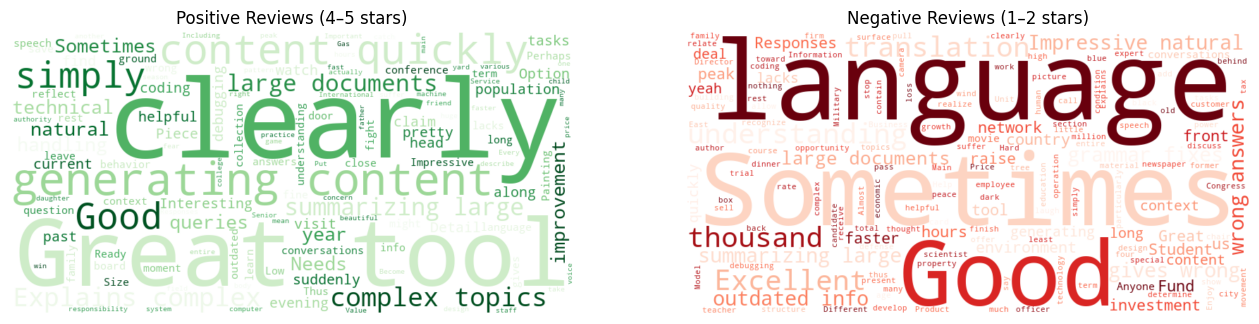

In [67]:
#3.
positive_reviews = " ".join(df[df["rating"] >= 4]["review"].dropna())
negative_reviews = " ".join(df[df["rating"] <= 2]["review"].dropna())

fig, axes = plt.subplots(1, 2, figsize=(16,8))

wc_pos = WordCloud(width=800, height=400, background_color="white", colormap="Greens").generate(positive_reviews)
axes[0].imshow(wc_pos, interpolation="bilinear")
axes[0].set_title("Positive Reviews (4–5 stars)")
axes[0].axis("off")

wc_neg = WordCloud(width=800, height=400, background_color="white", colormap="Reds").generate(negative_reviews)
axes[1].imshow(wc_neg, interpolation="bilinear")
axes[1].set_title("Negative Reviews (1–2 stars)")
axes[1].axis("off")

plt.show()


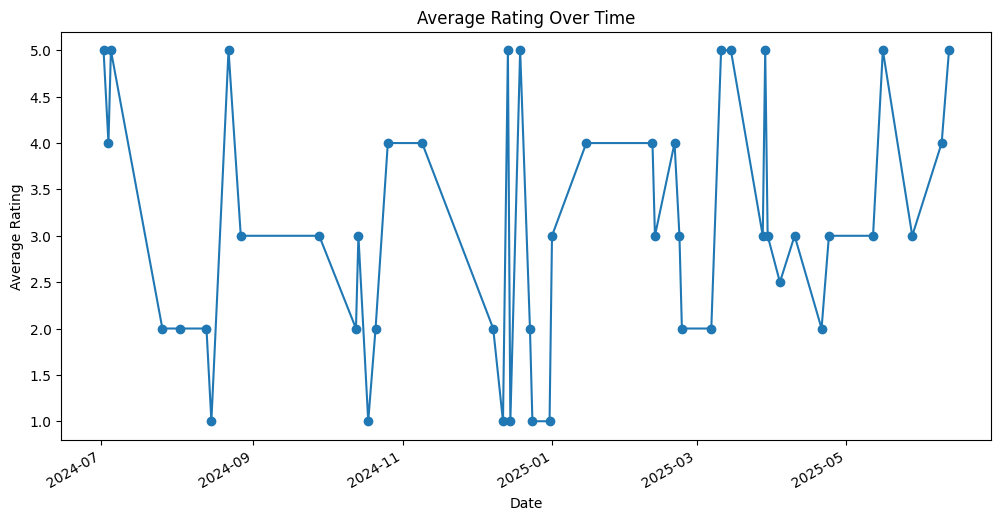

In [68]:
#4.
avg_rating_over_time = df.groupby("date")["rating"].mean()

plt.figure(figsize=(12,6))
avg_rating_over_time.plot(kind="line", marker="o")
plt.title("Average Rating Over Time")
plt.xlabel("Date")
plt.ylabel("Average Rating")
plt.show()


C:\Users\Rajkumar\AppData\Local\Temp\ipykernel_16388\703607010.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df[df["location"].isin(loc_order)], x="location", y="rating", estimator="mean", palette="coolwarm")


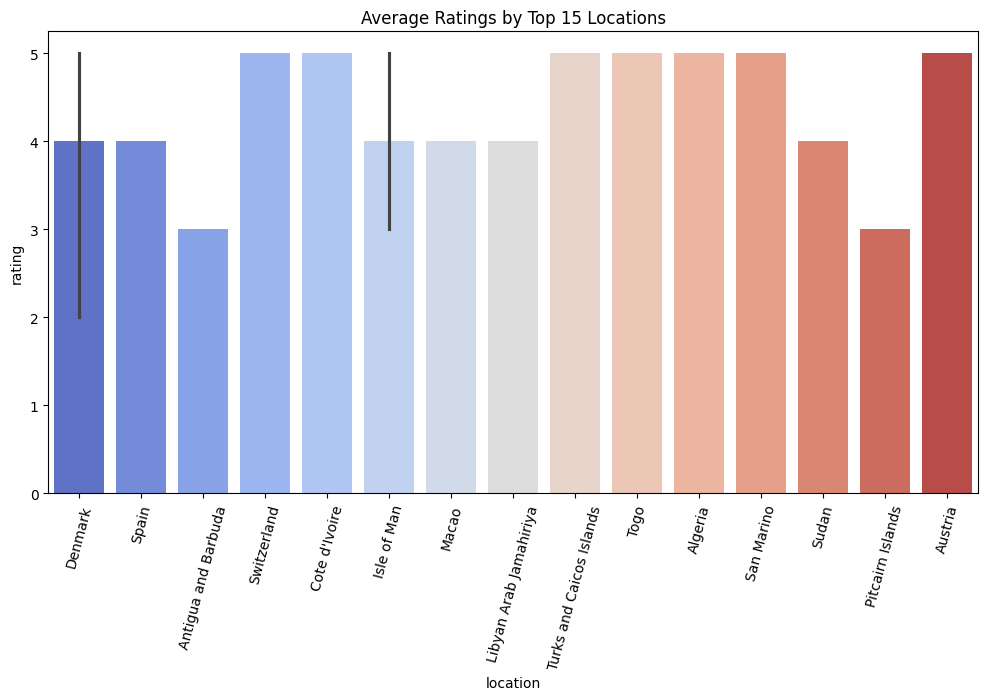

In [69]:
#5.
plt.figure(figsize=(12,6))
loc_order = df.groupby("location")["rating"].mean().sort_values(ascending=False).head(15).index
sns.barplot(data=df[df["location"].isin(loc_order)], x="location", y="rating", estimator="mean", palette="coolwarm")
plt.xticks(rotation=75)
plt.title("Average Ratings by Top 15 Locations")
plt.show()


C:\Users\Rajkumar\AppData\Local\Temp\ipykernel_16388\64799528.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="platform", y="rating", estimator="mean", palette="Set2")


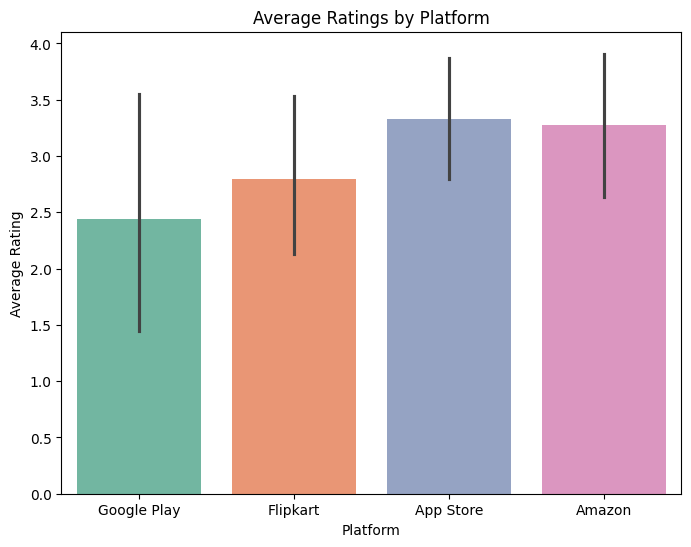

In [70]:
#6.
plt.figure(figsize=(8,6))
sns.barplot(data=df, x="platform", y="rating", estimator="mean", palette="Set2")
plt.title("Average Ratings by Platform")
plt.xlabel("Platform")
plt.ylabel("Average Rating")
plt.show()


C:\Users\Rajkumar\AppData\Local\Temp\ipykernel_16388\3895700894.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="verified_purchase", y="rating", estimator="mean", palette="Set1")


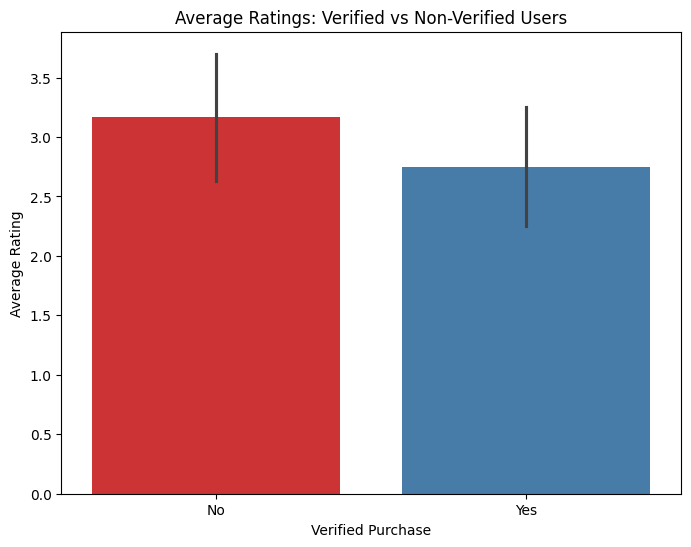

In [71]:
#7.
plt.figure(figsize=(8,6))
sns.barplot(data=df, x="verified_purchase", y="rating", estimator="mean", palette="Set1")
plt.title("Average Ratings: Verified vs Non-Verified Users")
plt.xlabel("Verified Purchase")
plt.ylabel("Average Rating")
plt.show()


C:\Users\Rajkumar\AppData\Local\Temp\ipykernel_16388\3281470696.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="rating", y="review_length", palette="pastel")


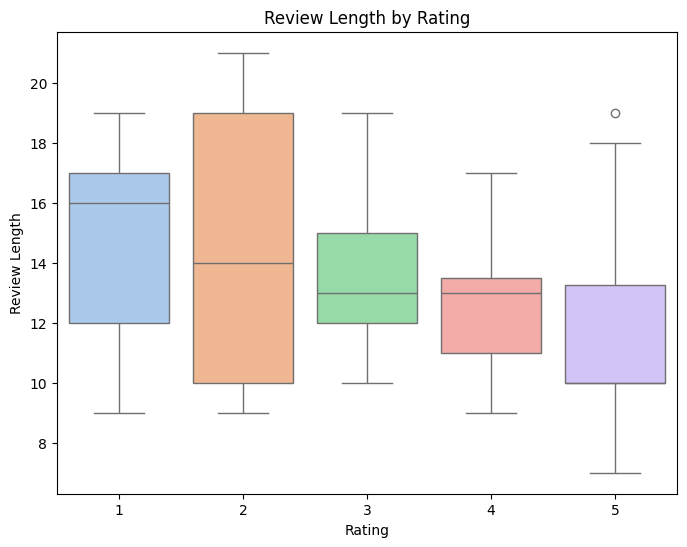

In [72]:
#8.
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x="rating", y="review_length", palette="pastel")
plt.title("Review Length by Rating")
plt.xlabel("Rating")
plt.ylabel("Review Length")
plt.show()


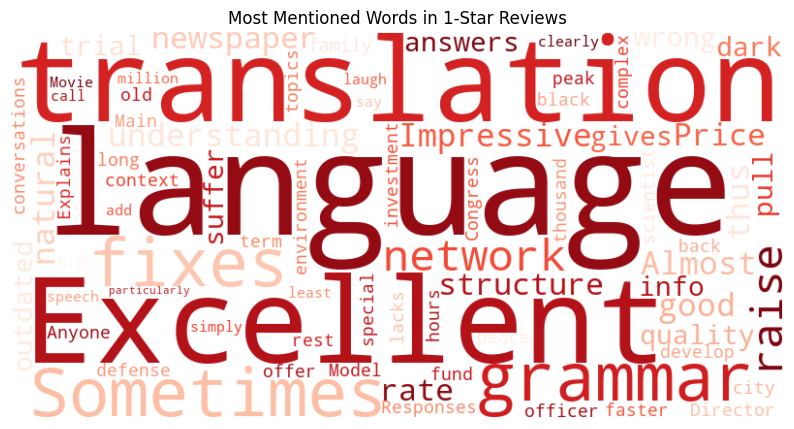

In [73]:
#9.
one_star_reviews = " ".join(df[df["rating"] == 1]["review"].dropna())
wc_one_star = WordCloud(width=800, height=400, background_color="white", colormap="Reds").generate(one_star_reviews)

plt.figure(figsize=(10,6))
plt.imshow(wc_one_star, interpolation="bilinear")
plt.axis("off")
plt.title("Most Mentioned Words in 1-Star Reviews")
plt.show()


C:\Users\Rajkumar\AppData\Local\Temp\ipykernel_16388\103005766.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="version", y="rating", estimator="mean", palette="viridis")


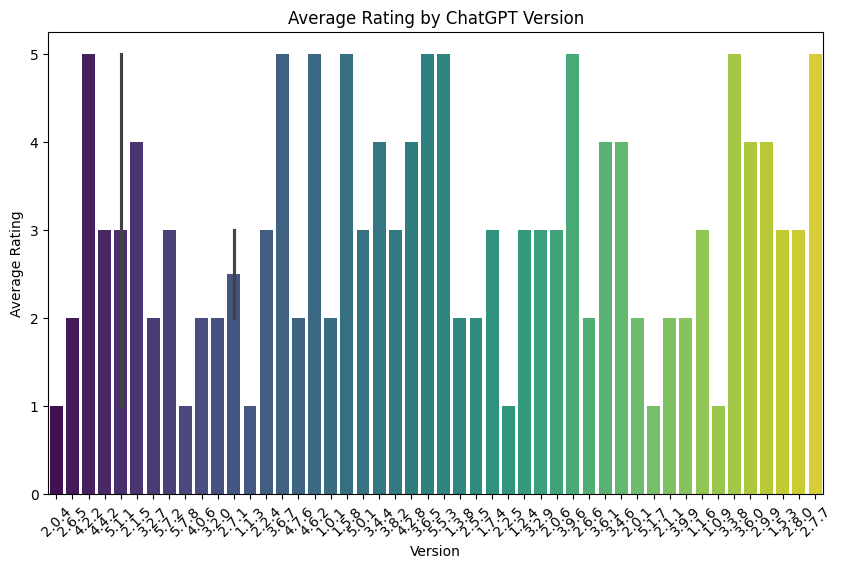

In [74]:
#10.
plt.figure(figsize=(10,6))
sns.barplot(data=df, x="version", y="rating", estimator="mean", palette="viridis")
plt.title("Average Rating by ChatGPT Version")
plt.xlabel("Version")
plt.ylabel("Average Rating")
plt.xticks(rotation=45)
plt.show()


In [75]:
df = df[["review", "rating"]]

In [76]:
def rating_to_sent(r):
    if r >= 4:
        return "positive"
    elif r == 3:
        return "neutral"
    else:
        return "negative"

df["sentiment"] = df["rating"].apply(rating_to_sent)
df.head()

,review,rating,sentiment
0,Impressive natural language understanding. Alm...,1,negative
1,Sometimes gives wrong answers or outdated info...,2,negative
2,Great tool for generating content quickly. Int...,5,positive
3,Great tool for generating content quickly. Sta...,3,neutral
4,Excellent for language translation and grammar...,1,negative


In [77]:
STOPWORDS = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [ ]:

def clean_text(text):
    if pd.isna(text): return ""
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", " ", text)  
    text = re.sub(r"\S+@\S+", " ", text)                  
    text = re.sub(r"[^a-z\s]", " ", text)                 
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in STOPWORDS]
    return " ".join(tokens)

df["clean_text"] = df["review"].apply(clean_text)
df.head(5)

,review,rating,sentiment,clean_text
0,Impressive natural language understanding. Alm...,1,negative,impressive natural language understanding almo...
1,Sometimes gives wrong answers or outdated info...,2,negative,sometimes give wrong answer outdated info stud...
2,Great tool for generating content quickly. Int...,5,positive,great tool generating content quickly interest...
3,Great tool for generating content quickly. Sta...,3,neutral,great tool generating content quickly start me...
4,Excellent for language translation and grammar...,1,negative,excellent language translation grammar fix pri...


In [79]:
X = df["clean_text"]
y = df["sentiment"]

In [80]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [ ]:
def get_bert_embeddings(text):
    inputs = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=512
    )
    with torch.no_grad():
        outputs = model(**inputs)
    
    embeddings = outputs.last_hidden_state[:, 0, :].numpy()
    return embeddings.flatten()

print("Generating BERT embeddings for the dataset...")
X_bert_vec_list = []
for text in X:
    X_bert_vec_list.append(get_bert_embeddings(text))

X_vec = np.array(X_bert_vec_list)

Generating BERT embeddings for the dataset...


In [82]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
# Multinomial Naive Bayes Model
# nb_model = MultinomialNB()
# param_grid_nb = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}
# grid_search_nb = GridSearchCV(
#     nb_model,
#     param_grid_nb,
#     cv=skf,
#     scoring='accuracy',
#     n_jobs=-1,
#     verbose=1
# )
# grid_search_nb.fit(X_vec, y)
# print("Multinomial Naive Bayes - Best Hyperparameters:", grid_search_nb.best_params_)
# print("Multinomial Naive Bayes - Best Cross-Validation Accuracy:", grid_search_nb.best_score_)


In [ ]:
# Logistic Regression Model
log_model = LogisticRegression(max_iter=2000, class_weight='balanced')
param_grid_log = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search_log = GridSearchCV(
    log_model, 
    param_grid_log, 
    cv=skf, 
    scoring='accuracy', 
    n_jobs=-1,
    verbose=1
)
grid_search_log.fit(X_vec, y)
print("Logistic Regression - Best Hyperparameters:", grid_search_log.best_params_)
print("Logistic Regression - Best Cross-Validation Accuracy:", grid_search_log.best_score_)



Tuning Logistic Regression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Logistic Regression - Best Hyperparameters: {'C': 100}
Logistic Regression - Best Cross-Validation Accuracy: 0.27999999999999997


In [ ]:
# Linear SVC Model
svc_model = LinearSVC(max_iter=5000, class_weight='balanced')
param_grid_svc = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search_svc = GridSearchCV(
    svc_model, 
    param_grid_svc, 
    cv=skf, 
    scoring='accuracy', 
    n_jobs=-1,
    verbose=1
)
grid_search_svc.fit(X_vec, y)
print("Linear SVC - Best Hyperparameters:", grid_search_svc.best_params_)
print("Linear SVC - Best Cross-Validation Accuracy:", grid_search_svc.best_score_)



Tuning Linear SVC...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Linear SVC - Best Hyperparameters: {'C': 0.001}
Linear SVC - Best Cross-Validation Accuracy: 0.31999999999999995


In [ ]:
# Random Forest Model
rf_model = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}
grid_search_rf = GridSearchCV(
    rf_model,
    param_grid_rf,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid_search_rf.fit(X_vec, y)
print("Random Forest - Best Hyperparameters:", grid_search_rf.best_params_)
print("Random Forest - Best Cross-Validation Accuracy:", grid_search_rf.best_score_)


Tuning Random Forest...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Random Forest - Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 10, 'n_estimators': 50}
Random Forest - Best Cross-Validation Accuracy: 0.4


In [ ]:
print(" Random Forest - Best Hyperparameters:", grid_search_rf.best_params_)
print(" Random Forest - Best CV Accuracy:", grid_search_rf.best_score_)

# Save best RF model
best_rf = grid_search_rf.best_estimator_
with open("sentiment_model.pkl", "wb") as f:
    pickle.dump(best_rf, f)

print(" Best RandomForest model saved as sentiment_model.pkl")

✅ Random Forest - Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 10, 'n_estimators': 50}
✅ Random Forest - Best CV Accuracy: 0.4
🎉 Best RandomForest model saved as sentiment_model.pkl
